# Dfrac 
Script to calculate the Dfrac of N2H+... 

from reproject import reproject_interp
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.units as u
import astropy.constants as const

import math
from astropy.constants import h, k_B, c

In [2]:
# Load Data 

# N2H+ data
hdu_n2hp = fits.open('./data/n2hp_mom0_reprojected.fits')[0]
hdu_n2hp_err = fits.open('./data/n2hp_mom0err_reprojected.fits')[0]

# N2D+ data
hdu_n2dp = fits.open('./data/n2dp_mom0.fits')[0]
hdu_n2dp_err = fits.open('./data/n2dp_mom0err.fits')[0]

In [3]:
mask1 = hdu_n2hp.data/hdu_n2hp_err.data < 10
mask2 = hdu_n2dp.data/hdu_n2dp_err.data < 10
mask = mask1 & mask2

hdu_n2hp.data[mask] = np.nan
hdu_n2hp_err.data[mask] = np.nan
hdu_n2dp.data[mask] = np.nan
hdu_n2dp_err.data[mask] = np.nan

In [4]:
def compute_g_j(j):
    """g-factors from quantum numbers"""
    return (2 * j) + 1

def compute_wavelength(freq):
    """Wavelength (m) from the frequency (Hz)"""
    return (c / freq).to(u.cm)

def compute_E_j(j, B):
    """Energy of the energy of level (J)"""
    return j * (j + 1) * h * B

def _compute_Q_rot(j, E_j, T_ex):
    """Compute the partition function for a molecule given the excitation temperature and rotational constant."""
    return (2 * j + 1) * np.exp((-E_j / (k_B * T_ex)).decompose().value)

def compute_partition_function(T_ex, B, maxJ=10):
    """
    Compute the partition function for a molecule given the excitation
    temperature and rotational constant.
    """
    Q_rot = 0.0
    for j in range(maxJ):
        E_j = compute_E_j(j, B)
        Q_rot += _compute_Q_rot(j, E_j, T_ex)
    return Q_rot

def compute_J_T(T, freq):
    """equivalent Rayleigh-Jeans temperatures"""
    return (h * freq / k_B) / (np.exp((h * freq / (k_B * T)).decompose().value) - 1.0)

def compute_column_density(I, eI, T_ex, T_bg,
                           freq, A, B, q_l, q_u, maxJ=10):
    """
    Compute the column density and its error for a molecular transition,
    given its integrated intensity (in K km/s) and associated error.

    Parameters
    ----------
    I : astropy.units.Quantity
        Integrated intensity in K km/s.
    eI : astropy.units.Quantity
        Uncertainty in the integrated intensity (same units as I).
    T_ex : float
        Excitation temperature in K.
    T_bg : float
        Background temperature in K.
    freq : astropy.units.Quantity
        Transition frequency (e.g., in Hz).
    A : float
        Einstein A coefficient (s^-1).
    B : astropy.units.Quantity
        Rotational constant (in Hz).
    l : float
        Lower rotational quantum number.
    u : float
        Upper rotational quantum number.
    maxJ : int, optional
        Maximum quantum number used in the partition function sum (default=10).
        
    Returns
    -------
    N : astropy.units.Quantity
        Column density in cm^-2.
    eN : astropy.units.Quantity
        Uncertainty in the column density in cm^-2.
    """
    # -----------------------------
    # Fundamental constants and derived quantities
    # -----------------------------
    # g-factors from quantum numbers
    g_l = compute_g_j(q_l)
    g_u = compute_g_j(q_u)

    # Wavelength (m) from the frequency (Hz)
    wavelength = compute_wavelength(freq) # c in m/s, freq in Hz → wavelength in m
    print('Wavelength', wavelength)
    print('hv/k', (h * freq / k_B).to('K'))

    # Energy of the lower level (J)
    E_l = compute_E_j(q_l, B)
    print('E_l', E_l)

    # -----------------------------
    # Partition function: Q_rot = sum_{j=0}^{maxJ-1} (2j+1) exp[-E_j/(k_B T_ex)]
    # where E_j = j(j+1) h B.
    # -----------------------------
    Q_rot = compute_partition_function(T_ex, B, maxJ=maxJ)
    print('Q_rot', Q_rot)
    
    # -----------------------------
    # Brightness temperature correction:
    # J(T) = (h*nu/k_B) / (exp(h*nu/(k_B*T)) - 1)
    # -----------------------------
    # Note: we use .decompose().value to work with dimensionless arguments inside np.exp.
    J_ex = compute_J_T(T_ex, freq)
    J_bg = compute_J_T(T_bg, freq)
    print('J_ex', J_ex)
    print('J_bg', J_bg)
    
    # -----------------------------
    # Compute the prefactor (fcol) in the column density equation:
    #
    # N = fcol * (integrated intensity)    where:
    #
    #   fcol = (8π/(λ^3 A)) * (g_l/g_u) * 1/(J_ex - J_bg) *
    #          1/(1 - exp(-h*freq/(k_B*T_ex))) * Q_rot *
    #          1/(g_l * exp(-E_l/(k_B*T_ex)))
    # -----------------------------
    top_factor      = (8 * np.pi) / (wavelength**3 * A)
    factor_degen    = g_l / g_u
    factor_J        = 1.0 / (J_ex - J_bg)
    factor_exp_term = 1.0 / (1.0 - np.exp((-h * freq / (k_B * T_ex)).decompose().value))
    factor_level    = Q_rot / (g_l * np.exp((-E_l / (k_B * T_ex)).decompose().value))
    
    fcol = top_factor * factor_degen * factor_J * factor_exp_term * factor_level
    
    # -----------------------------
    # Compute the column density (N) in cm^-2.
    # (I is in K km/s; 'conv' converts to appropriate base units.)
    # -----------------------------
    N_val = I *  fcol
    N_err = eI * fcol

    # Likely the units come out as m^-2; convert to cm^-2.
    N = N_val.to(u.cm**-2)
    N_err = N_err.to(u.cm**-2)
    
    return N, N_err

In [5]:
# ------------------------------------------------------------------------------
# Example usage for N2H+ (1-0) and N2D+ (1-0)
# ------------------------------------------------------------------------------

# Example inputs (integrated intensities with errors in K km/s)
# Assume these values are measured from your observations.

# For N2H+ (1-0)
I_n2hp  = hdu_n2hp.data * u.K * u.km / u.s
eI_n2hp = hdu_n2hp_err.data * u.K * u.km / u.s
T_ex    = 4.5      # in K
T_bg    = 2.72548  # in K

# Constants for N2H+ (1-0)
freq_n2hp = 93.1762522e9 * u.Hz      # frequency in Hz
A_n2hp    = 3.6280e-5 / u.s                 # Einstein A [s^-1]
B_n2hp    = 46586.8713e6 * u.Hz       # Rotational constant [Hz]
l_n2hp    = 0.0                     # lower level quantum number
u_n2hp    = 1.0                     # upper level quantum number

# Factor to convert from isolated hyperfine component to total column density
# (assuming optically thin emission)
I_n2hp = I_n2hp / 0.111
eI_n2hp = eI_n2hp / 0.111

N_n2hp, eN_n2hp = compute_column_density(I_n2hp, eI_n2hp,
                                            T_ex, T_bg,
                                            freq_n2hp, A_n2hp, B_n2hp,
                                            l_n2hp, u_n2hp, maxJ=10)

print("\nN2H+ (1-0):")
print("   Mean column density: {:.2e} ± {:.2e}".format(np.nanmean(N_n2hp), np.nanmean(eN_n2hp)))
print("   Median column density: {:.2e} ± {:.2e}".format(np.nanmedian(N_n2hp), np.nanmedian(eN_n2hp)))

Wavelength 0.32174771030337707 cm
hv/k 4.471754829730741 K
E_l 0.0 Hz J s
Q_rot 2.3827636147468145
J_ex 2.628475118143428 Hz K s
J_bg 1.0752272994394392 Hz K s

N2H+ (1-0):
   Mean column density: 2.24e+13 1 / cm2 ± 1.00e+12 1 / cm2
   Median column density: 1.97e+13 1 / cm2 ± 9.59e+11 1 / cm2


In [6]:
# For N2D+ (1-0)
I_n2dp  = hdu_n2dp.data * u.K * u.km / u.s
eI_n2dp = hdu_n2dp_err.data * u.K * u.km / u.s

# We assume the same T_ex and T_bg.. 

# Use typical values for N2D+ (1-0) [example values]:
freq_n2dp = 77.109e9 * u.Hz         # frequency in Hz (approximate)
A_n2dp    = 2.07e-5 / u.s           # Einstein A [s^-1] (example scaling)
B_n2dp    = 38554.7479e6 * u.Hz     # Rotational constant [Hz]
l_n2dp    = 0.0                     # for a 1-0 transition, lower state = 0
u_n2dp    = 1.0                     # for 1-0, upper state = 1

N_n2dp, eN_n2dp = compute_column_density(I_n2dp, eI_n2dp,
                                            T_ex, T_bg,
                                            freq_n2dp, A_n2dp, B_n2dp,
                                            l_n2dp, u_n2dp, maxJ=10)

print("\nN2D+ (1-0):")
print("   Mean column density: {:.2e} ± {:.2e}".format(np.nanmean(N_n2dp), np.nanmean(eN_n2dp)))
print("   Median column density: {:.2e} ± {:.2e}".format(np.nanmedian(N_n2dp), np.nanmedian(eN_n2dp)))

Wavelength 0.38879048878859795 cm
hv/k 3.7006483414419593 K
E_l 0.0 Hz J s
Q_rot 2.795146111564262
J_ex 2.9004699452960816 Hz K s
J_bg 1.2815569493857122 Hz K s

N2D+ (1-0):
   Mean column density: 1.70e+12 1 / cm2 ± 1.96e+11 1 / cm2
   Median column density: 1.43e+12 1 / cm2 ± 1.95e+11 1 / cm2


In [7]:
def compute_Dfrac(N_n2dp, eN_n2dp, N_n2hp, eN_n2hp):
    """
    Compute the deuterium fraction map, f_D = N(N2D+)/N(N2H+), and its
    uncertainty for 2D arrays (maps) of column densities.

    Parameters
    ----------
    N_n2dp : astropy.units.Quantity
        2D array of column densities for N2D+ (e.g., in cm^-2).
    eN_n2dp : astropy.units.Quantity
        2D array of uncertainties for the N2D+ column densities.
    N_n2hp : astropy.units.Quantity
        2D array of column densities for N2H+ (e.g., in cm^-2).
    eN_n2hp : astropy.units.Quantity
        2D array of uncertainties for the N2H+ column densities.

    Returns
    -------
    f_D : astropy.units.Quantity
        2D array of deuterium fraction values (dimensionless).
    e_f_D : astropy.units.Quantity
        2D array of uncertainties in the deuterium fraction (dimensionless).
    """
    # Calculate the deuterium fraction map
    f_D = N_n2dp / N_n2hp

    # Compute the relative errors for each map.
    # To avoid division by zero, use np.where to set relative error to zero where the value is zero.
    rel_err_n2dp = np.where(N_n2dp.value != 0, (eN_n2dp / N_n2dp).decompose().value, 0.0)
    rel_err_n2hp = np.where(N_n2hp.value != 0, (eN_n2hp / N_n2hp).decompose().value, 0.0)

    # Propagate the error for the ratio (assuming independent errors)
    e_f_D = f_D * np.sqrt(rel_err_n2dp**2 + rel_err_n2hp**2)

    return f_D, e_f_D

f_D, e_f_D = compute_Dfrac(N_n2dp, eN_n2dp, N_n2hp, eN_n2hp)
print("\nDeuterium fraction")
print("  Mean f_D:", np.nanmean(f_D))
print("  Median f_D:", np.nanmedian(f_D))


Deuterium fraction
  Mean f_D: 0.07903034487518175
  Median f_D: 0.0777381905675563


In [8]:
hdu_f_D = fits.PrimaryHDU(f_D.value, header=hdu_n2dp.header)
hdu_f_D_err = fits.PrimaryHDU(e_f_D.value, header=hdu_n2dp.header)

hdu_f_D.writeto('./data/dfrac_n2dp_n2hp.fits', overwrite=True)
hdu_f_D_err.writeto('./data/dfrac_n2dp_n2hp_err.fits', overwrite=True)

Text(0, 0.5, 'N2D+ Column Density')

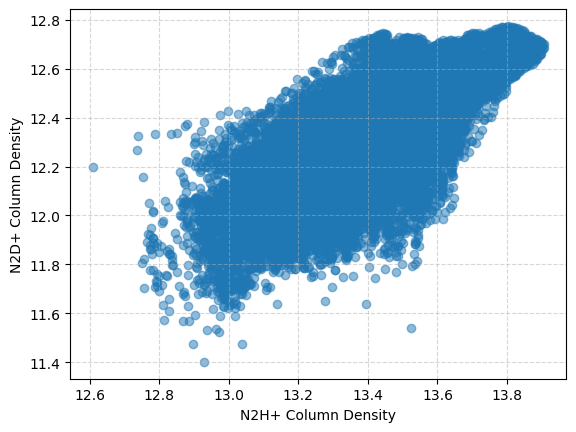

In [9]:
data1 = N_n2hp.value    
data2 = N_n2dp.value
data1_err = eN_n2hp.value
data2_err = eN_n2dp.value

mask1 = data1/data1_err > 5
mask2 = data2/data2_err > 5
mask = mask1 & mask2

data1 = data1[mask]
data2 = data2[mask]
data1_err = data1_err[mask]
data2_err = data2_err[mask]

data1 = np.log10(data1)
data2 = np.log10(data2)

plt.scatter(data1, data2, alpha=0.5)
plt.grid(ls='--', alpha=0.5)
plt.xlabel('N2H+ Column Density')
plt.ylabel('N2D+ Column Density')